In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:

# 数据加载和预处理
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)


In [3]:
# 判别器网络
class Discriminator(nn.Module):
    def __init__(self, conditional=False):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 输入是 3 x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False) if not conditional else nn.Conv2d(6, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 状态大小. (64) x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 状态大小. (128) x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 状态大小. (256) x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # 状态大小. (512) x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)


In [4]:
# 生成器网络
class Generator(nn.Module):
    def __init__(self, conditional=False):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # 输入是 Z, 进入卷积
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False) if not conditional else nn.ConvTranspose2d(200, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 状态大小. (512) x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 状态大小. (256) x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 状态大小. (128) x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 状态大小. (64) x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # 最终状态大小. (3) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


In [5]:
# 创建判别器和生成器实例
netD = Discriminator().to(device)
netG = Generator().to(device)


In [10]:
# 初始化权重
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [7]:
# 初始化权重
netD.apply(weights_init)
netG.apply(weights_init)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [8]:
# 损失函数和优化器
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [9]:
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
real_label = 1
fake_label = 0
# 训练过程
num_epochs = 50
img_list = []

In [10]:
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        # 训练判别器: 最大化 log(D(x)) + log(1 - D(G(z)))
        ## 更新判别器网络: maximize log(D(x)) + log(1 - D(G(z)))
        netD.zero_grad()
        # 训练真实图像
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # 训练假图像
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # 更新生成器网络: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(train_loader)}] Loss_D: {errD.item()} Loss_G: {errG.item()} D(x): {D_x} D(G(z)): {D_G_z1}/{D_G_z2}')

    # 每个epoch结束时保存生成器的输出
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    # 保存模型
    if not os.path.exists('./model/'):
        os.makedirs('./model/')
    torch.save(netG.state_dict(), f'./model/netG_epoch_{epoch}.pth')
    torch.save(netD.state_dict(), f'./model/netD_epoch_{epoch}.pth')




[0/50][0/49] Loss_D: 1.588804006576538 Loss_G: 5.207036018371582 D(x): 0.46077612042427063 D(G(z)): 0.4328998923301697/0.009773069992661476
[1/50][0/49] Loss_D: 0.1427496373653412 Loss_G: 8.131084442138672 D(x): 0.9148446321487427 D(G(z)): 0.03254421055316925/0.0004095873737242073
[2/50][0/49] Loss_D: 0.4323013722896576 Loss_G: 4.910771369934082 D(x): 0.9210910797119141 D(G(z)): 0.26193028688430786/0.01114446297287941
[3/50][0/49] Loss_D: 0.24172928929328918 Loss_G: 4.931095123291016 D(x): 0.8808901906013489 D(G(z)): 0.08565448224544525/0.008797349408268929
[4/50][0/49] Loss_D: 0.524189829826355 Loss_G: 3.5242414474487305 D(x): 0.9126363396644592 D(G(z)): 0.3078318238258362/0.045652762055397034
[5/50][0/49] Loss_D: 0.5718964338302612 Loss_G: 3.5984561443328857 D(x): 0.7302331924438477 D(G(z)): 0.14721086621284485/0.04845987632870674
[6/50][0/49] Loss_D: 0.3944820463657379 Loss_G: 3.3241052627563477 D(x): 0.8263170719146729 D(G(z)): 0.15339668095111847/0.04898358881473541
[7/50][0/49] L

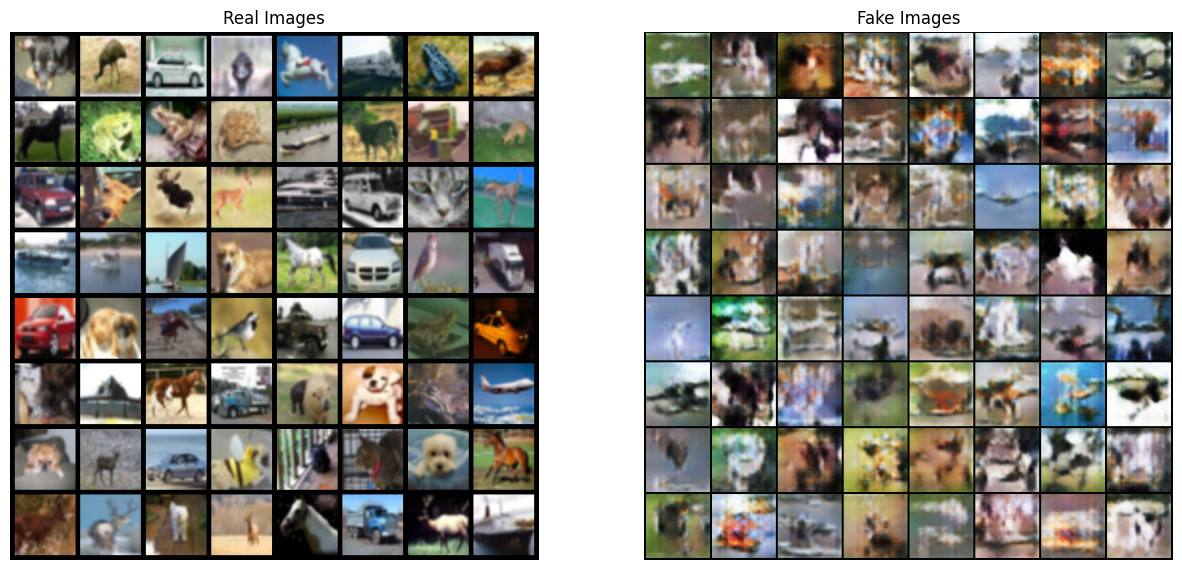

In [11]:
# 显示生成的图像
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_cpu.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [30]:
# 数据加载和预处理
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)


Files already downloaded and verified


In [22]:
# 条件生成器网络
class ConditionalGenerator(nn.Module):
    def __init__(self):
        super(ConditionalGenerator, self).__init__()
        self.label_embedding = nn.Embedding(10, 100)
        # self.projector = nn.Linear(640, 100)
        self.model = Generator(conditional=True)  # 与前面的生成器相同
        # self.factor = nn.Parameter(torch.ones(1))

    def forward(self, noise, labels):
        # print(noise.shape, labels.shape)
        # 将标签转换为one-hot向量
        c = self.label_embedding(labels)
        # print(c.shape)
        # c = c.view(c.size(0), -1)
        # c = self.projector(c)
        c = c.view(c.size(0), 100, 1, 1)
        # x = self.factor * c + noise
        x = torch.cat([c, noise], dim=1)
        # print(x.shape)
        return self.model(x)
    


In [23]:
# 条件判别器网络
class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()
        self.label_embedding = nn.Embedding(10, 64 * 64 * 3)
        # self.projector = nn.Linear(640, 64 * 64 * 3)
        self.model = Discriminator(conditional=True)  # 与前面的判别器相同
        # trainable factor
        self.factor = nn.Parameter(torch.ones(1))

    def forward(self, img, labels):
        # 将标签转换为one-hot向量
        c = self.label_embedding(labels)
        # print(c.shape)
        # print(img.shape)
        # print(labels.shape)
        # c = c.view(c.size(0), -1)
        # c = self.projector(c)
        c = c.view(c.size(0), 3, 64, 64)
        # x = self.factor * c + img
        # print(c.shape, img.shape)
        x = torch.cat([img, c], 1)
        return self.model(x)


In [36]:
# 创建条件生成器和条件判别器实例
netG = ConditionalGenerator().to(device)
netD = ConditionalDiscriminator().to(device)


In [37]:
# 初始化权重
netD.apply(weights_init)
netG.apply(weights_init)


ConditionalGenerator(
  (label_embedding): Embedding(10, 100)
  (model): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(200, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTran

In [38]:

# 权重初始化和优化器设置与前面相同
# 生成噪声向量，用于在训练过程中观察生成器的进展
fixed_noise = torch.randn(64, 100, 1, 1, device=device)
fixed_labels = torch.randint(0, 10, (64,), device=device)

criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0003, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0003, betas=(0.5, 0.999))

# 训练循环
num_epochs = 50
img_list = []


In [39]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        netD.zero_grad()
        real_cpu = images.to(device)
        batch_size = real_cpu.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # 训练判别器 - 真实数据
        output = netD(real_cpu, labels.to(device))
        errD_real = criterion(output, real_labels.squeeze(1))
        errD_real.backward()
        D_x = output.mean().item()

        # 生成假图像
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        random_labels = torch.randint(0, 10, (batch_size,), device=device)
        fake = netG(noise, random_labels)
        output = netD(fake.detach(), random_labels)

        # 训练判别器 - 假数据
        errD_fake = criterion(output, fake_labels.squeeze(1))
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # 更新生成器
        netG.zero_grad()
        # output = netD(fake, fake_labels_onehot)
        output = netD(fake, random_labels)
        errG = criterion(output, real_labels.squeeze(1))
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(train_loader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    with torch.no_grad():
        # fix_labels_onehot = torch.zeros(64, 10).to(device)
        # fix_labels_onehot.scatter_(1, fixed_labels.view(-1, 1), 1)  # Fix: Change random_labels.view(-1, 10) to random_labels.view(-1, 1)
        # fix_labels_onehot = fix_labels_onehot.long().to(device)
        # # print(fixed_noise.shape, fix_labels_onehot.shape)
        # fake = netG(fixed_noise, fix_labels_onehot).detach().cpu()
        fake = netG(fixed_noise, fixed_labels).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    if not os.path.exists('./model/'):
        os.makedirs('./model/')
    torch.save(netG.state_dict(), f'./model/conditional_netG_epoch_{epoch}.pth')
    torch.save(netD.state_dict(), f'./model/conditional_netD_epoch_{epoch}.pth')


[0/50][0/49] Loss_D: 2.1319 Loss_G: 11.5806 D(x): 0.7702 D(G(z)): 0.7630 / 0.0957
[1/50][0/49] Loss_D: 1.2592 Loss_G: 3.7031 D(x): 0.6836 D(G(z)): 0.3817 / 0.0478
[2/50][0/49] Loss_D: 0.9599 Loss_G: 4.4625 D(x): 0.6496 D(G(z)): 0.1804 / 0.0370
[3/50][0/49] Loss_D: 1.0465 Loss_G: 2.6737 D(x): 0.5525 D(G(z)): 0.1585 / 0.1096
[4/50][0/49] Loss_D: 1.4471 Loss_G: 1.8389 D(x): 0.3945 D(G(z)): 0.0289 / 0.2276
[5/50][0/49] Loss_D: 0.6286 Loss_G: 2.8441 D(x): 0.7403 D(G(z)): 0.1934 / 0.0910
[6/50][0/49] Loss_D: 0.7213 Loss_G: 2.3441 D(x): 0.6814 D(G(z)): 0.1962 / 0.1256
[7/50][0/49] Loss_D: 1.0700 Loss_G: 5.3102 D(x): 0.8637 D(G(z)): 0.5241 / 0.0121
[8/50][0/49] Loss_D: 0.4579 Loss_G: 3.0920 D(x): 0.7854 D(G(z)): 0.1298 / 0.0759
[9/50][0/49] Loss_D: 0.9573 Loss_G: 6.9445 D(x): 0.9256 D(G(z)): 0.5454 / 0.0026
[10/50][0/49] Loss_D: 0.6886 Loss_G: 3.3958 D(x): 0.8374 D(G(z)): 0.3520 / 0.0481
[11/50][0/49] Loss_D: 0.5106 Loss_G: 2.8320 D(x): 0.7623 D(G(z)): 0.1542 / 0.0889
[12/50][0/49] Loss_D: 2.4

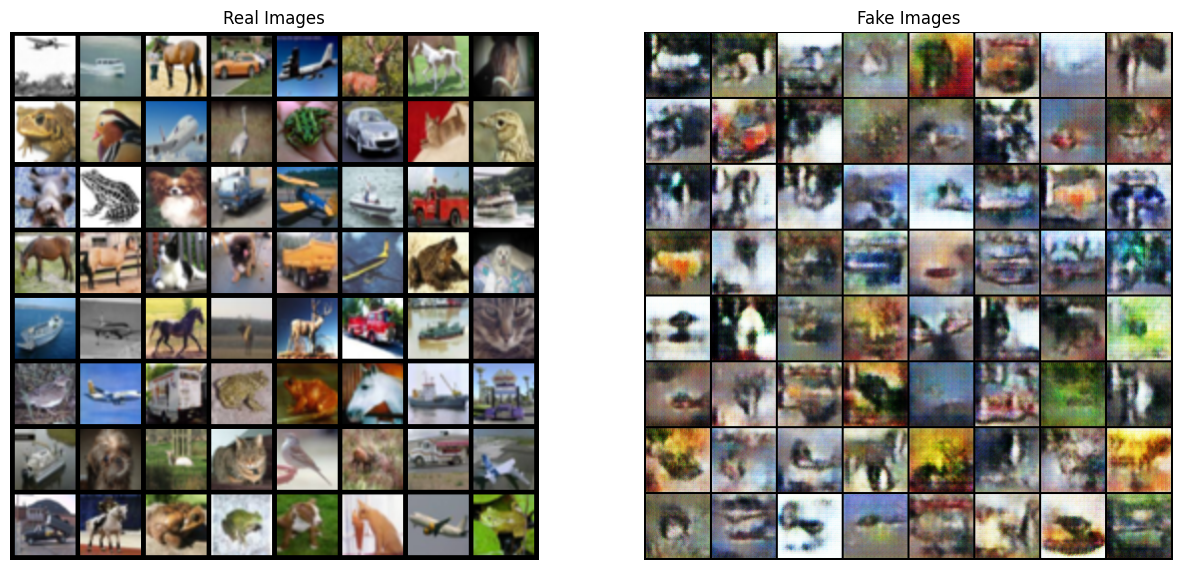

In [40]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_cpu.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()
